# In this notebook I implement a Bayesian Neural Net for classification with tensor flow


In [1]:
#%% imports 
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
from sklearn import datasets
import numpy as np
import scipy.io as scio
import numpy.random as rng
import tensorflow as tf
import matplotlib.pyplot as plt
rng.seed(1)
tf.set_random_seed(1);
import tensorflow as tf
from scipy.stats import mode

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Build the model class

In [2]:
#%% Bayesian neural net model
class bayesian_neural_net:
    def __init__(self, layer_sizes, activationFn = tf.nn.tanh):
        self.dataType = tf.float64;
        self.layer_sizes = layer_sizes;
        self.dim_weights = zip(self.layer_sizes[0:-1], self.layer_sizes[1:])
        self.dim_biases = self.layer_sizes[1:]
        self.nweights = np.sum([np.prod(self.dim_weights[i]) for i in range(len(self.dim_weights))]);
        self.nbiases = np.sum(self.dim_biases);
        self.X = tf.placeholder(shape = [None,self.layer_sizes[0]], dtype=self.dataType, name='X');
        self.y = tf.placeholder(shape = [None,self.layer_sizes[-1]], dtype=self.dataType, name ='y');
        self.activationFn = activationFn;
        # proposal distribution of z = f(X), z_i~q_i = N(m_i, exp(tau_i)), i \in {1, .... , m}
        self.mu_z = tf.Variable(initial_value= 0.*tf.truncated_normal(shape = [self.nweights+self.nbiases], stddev = 0.1, dtype=self.dataType), name='mu_z');
        self.tau_z = tf.Variable(initial_value=0.*tf.truncated_normal(shape = [self.nweights+self.nbiases], stddev = 0.1, dtype=self.dataType), name='tau_z');
        self.sigma_z = tf.nn.softplus(self.tau_z);
        self.z = self.mu_z + tf.random_normal(shape = self.sigma_z.get_shape(), dtype = self.dataType) * self.sigma_z;

    def neural_net(self, z, X):
        layer_sizes = self.layer_sizes;
        dim_weights = self.dim_weights;
        dim_biases = self.dim_biases;
        net = tf.cast(X, dtype=self.dataType);
        pt_w = 0;
        pt_b = self.nweights;
        for i in range(len(layer_sizes[1:])):
            pt_w = np.array([0, np.prod(dim_weights[i])]);
            pt_b = np.array([0, dim_biases[i]]);
            W = tf.reshape(z[pt_w[0]:pt_w[1]],  dim_weights[i]  );
            b = z[pt_b[0]:pt_b[1]];
            if i < (len(layer_sizes[1:])-1):
                net = self.activationFn(tf.matmul(net , W) + b);
            else:
                net = tf.nn.softmax(tf.matmul(net , W) + b);
            pt_w = pt_w+np.prod(dim_weights[i]);
            pt_b = pt_b+dim_biases[i];
                    
        out = net;
        return out
    
    ##### pred_label: returns the label prediction #####
    def pred_label(self, z, X):
        out = self.neural_net(z, X);
        predict = tf.argmax(out, 1);
        return predict
    
    ##### pred_error: returns the prediction error #####
    def pred_error(self, z, X, y):
        predict = self.pred_label(z, X)
        label = tf.argmax(y, 1)
        correct = tf.reduce_sum(tf.cast(tf.equal(predict, label), dtype=self.dataType))/tf.cast(tf.shape(label)[0], dtype = self.dataType);
        per_error = (1.-correct)*100.;
        return per_error
    
    ##### logprior_prob: returns the log prior probability of the latent z #####
    def logprior_prob(self, z):
        """the prior = p(z) = N(0, sI)"""
        s = 1.;
        logprior =  -tf.cast( 0.5 / s * (tf.reduce_sum(z**2)), dtype=self.dataType) - 0.5 * tf.cast(tf.shape(z)[0],dtype = self.dataType) * np.log(2*np.pi*s);
        return logprior;
    
    ##### loglik_prob: returns the log likelihood probability of the latent z #####
    def loglik_prob(self, z, X, y):
        """the log likelihood is bernaulli"""
        out = self.neural_net(z, X);
        # model params
        loglik = tf.reduce_sum(tf.reduce_sum((y * tf.log(out)),1));
        return loglik
    
    ##### logjoint_prob: returns the log joint probability (unnormalized posterior) of the latent z #####
    def logjoint_prob(self, z):
        """ joint probability """
        logjoint = self.loglik_prob(z, self.X, self.y) + self.logprior_prob(z);
        return logjoint
    
    ##### logq_prob: returns the log of the proposal probability of the latent z #####
    def logq_prob(self, z):
        """ Mean field proposal distribution which is the same as the posterior approximate"""
        logq = -0.5 * tf.reduce_sum(((z-self.mu_z)/self.sigma_z)**2)- tf.reduce_sum(tf.log(self.sigma_z)) - 0.5 * tf.cast(tf.shape(z)[0],dtype = self.dataType) * np.log(2*np.pi);
        return logq
    
    ##### sample_model: function used to sample from the proposal distribution and return the probability of all model elements #####
    def sample_model(self, nsamples):
        z = [];
        logprior_prob = [];
        loglik_prob = [];
        logjoint_prob = [];
        logq_prob = [];
        for i in range(nsamples):
            z += [self.mu_z + tf.random_normal(shape = self.sigma_z.get_shape(), dtype = self.dataType) * self.sigma_z];
            #"z are one sample of the network weights"
            logprior_prob += [self.logprior_prob(z[i])];
            loglik_prob += [self.loglik_prob(z[i], self.X, self.y)];
            logjoint_prob += [self.logjoint_prob(z[i])];
            logq_prob += [self.logq_prob(z[i])];
        return tf.pack(logprior_prob), tf.pack(loglik_prob), tf.pack(logjoint_prob), tf.pack(logq_prob), tf.pack(z)


# Load Data

Extracting /Users/gamal/exploration/data/MNIST/train-images-idx3-ubyte.gz
Extracting /Users/gamal/exploration/data/MNIST/train-labels-idx1-ubyte.gz
Extracting /Users/gamal/exploration/data/MNIST/t10k-images-idx3-ubyte.gz
Extracting /Users/gamal/exploration/data/MNIST/t10k-labels-idx1-ubyte.gz
training data points 55000
testing data points 10000
validation data points 5000
image size is 28 x 28


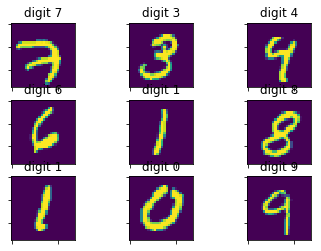

In [6]:
#%% download and store data 
#%% download and store data 
from tensorflow.examples.tutorials import mnist
directory = '/Users/gamal/exploration/'
mnist_data = mnist.input_data.read_data_sets(directory + 'data/MNIST', one_hot=True)
train_data =  mnist_data.train; #{'images': mnist_data.train.images, 'labels': mnist_data.train.labels};
test_data =  mnist_data.test; #{'images': mnist_data.test.images, 'labels': mnist_data.test.labels};
validation_data =  mnist_data.validation; #{'images': mnist_data.validation.images, 'labels': mnist_data.validation.labels};
num_classes = 10;

l = int(np.sqrt(train_data.images.shape[1]));
digits = np.array(range(num_classes)); # possible digits
"""
data structure:
    mnist_data.train 55,000 training digit images each of size (28 x 28)
    mnist_data.test 10,000 testing images    
    mnist_data.validation 5,000 testing images
"""

print "training data points %d"  %train_data.images.shape[0];
print "testing data points %d"  %test_data.images.shape[0];
print "validation data points %d"  %validation_data.images.shape[0];
print "image size is %d x %d"  %(l, l);

_, axarr= plt.subplots(3,3)
for i in range(9):
    axarr[i/3, i%3].imshow(np.reshape(train_data.images[i, :], (l, l)));
    axarr[i/3, i%3].set_title(('digit %d' %digits[train_data.labels[i, :].astype('bool')]))
    axarr[i/3, i%3].set_xticklabels(' ')
    axarr[i/3, i%3].set_yticklabels(' ')
plt.show('all')

# Build inference

In [7]:

nsamples = 5;
layer_sizes = [int(l**2), 100, num_classes];
graph = tf.Graph();
with graph.as_default():
    mdl = bayesian_neural_net(layer_sizes);
    # # # ## VB_objective 
    logprior_prob, loglik_prob, logjoint_prob, logq_prob, z = mdl.sample_model(nsamples)
    ELBO =  tf.reduce_mean(logjoint_prob - logq_prob);
    # Training the model
    learning_rate = 0.2;
    optimizer = tf.train.AdamOptimizer(learning_rate)
    cost = -ELBO;
    tvars = tf.trainable_variables()
    grads = tf.gradients(cost, tvars);
    grads, _ = tf.clip_by_global_norm(grads, 10)
    grads_and_vars = zip(grads, tvars);
    train_step = optimizer.apply_gradients(grads_and_vars)


# optimize

In [9]:
maxiter =100;
ELBO_list = [];
test_error = [];
with tf.Session(graph=graph) as sess:
    init = tf.initialize_all_variables()
    feed_dict = {mdl.X: train_data.images, mdl.y:train_data.labels}
    sess.run(init);
    for i in range(maxiter):
        sess.run(train_step, feed_dict=feed_dict)
        test_error +=[sess.run(mdl.pred_error(mdl.z, test_data.images, test_data.labels))]
        ELBO_list.append(sess.run(ELBO, feed_dict=feed_dict));
        print ("iter %d, prediction error = %.2f %%" %(i, test_error[i]))

iter 0, prediction error = 90.43 %
iter 1, prediction error = 90.11 %
iter 2, prediction error = 90.26 %
iter 3, prediction error = 88.37 %
iter 4, prediction error = 85.11 %
iter 5, prediction error = 81.77 %
iter 6, prediction error = 80.46 %
iter 7, prediction error = 82.80 %
iter 8, prediction error = 77.87 %
iter 9, prediction error = 69.86 %
iter 10, prediction error = 87.62 %
iter 11, prediction error = 54.28 %
iter 12, prediction error = 67.16 %
iter 13, prediction error = 56.50 %
iter 14, prediction error = 67.83 %
iter 15, prediction error = 72.06 %
iter 16, prediction error = 59.78 %
iter 17, prediction error = 58.33 %
iter 18, prediction error = 65.97 %
iter 19, prediction error = 49.91 %
iter 20, prediction error = 54.63 %
iter 21, prediction error = 47.62 %
iter 22, prediction error = 53.21 %
iter 23, prediction error = 51.19 %
iter 24, prediction error = 56.01 %
iter 25, prediction error = 48.85 %
iter 26, prediction error = 44.13 %
iter 27, prediction error = 40.80 %
it

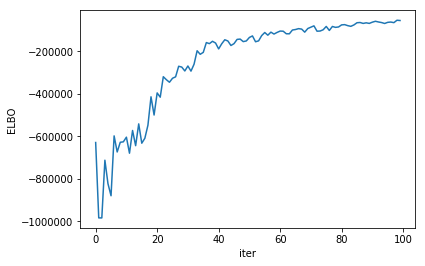

In [10]:
plt.plot(ELBO_list)
plt.xlabel('iter')
plt.ylabel('ELBO')
plt.show()